# Chaos in Periodically-Driven Systems

## KR1: RK-4 Scheme

### Preliminary

- Call .jl file containing modules with functions. 
- Import necessary packages.

In [1]:
using BenchmarkTools
using Plots
using FFTW
using DelimitedFiles

include("spinning_compass_functions.jl");

## Implementation

- Use `help` to obtain doc string of RK-4 numerical integrator function.

In [2]:
? Spin_compass.RK4()

```
RK4(eom_func, t_param, r)
```

Solve systems of first-order ordinary differential equations using the fourth-order Runge-Kutta method.

# Args

  * eom*func (Function): function corresponding to the equations of motion to be integrated. The function must follow the format: `eom*func(r, t)`.
  * time*param (Tuple): initial and final time, and number of steps of the integration. `time*param`must follow the format:`time*param = [t*initial, t_final, Npoints]`
  * r (Array): initial state of the system. r must follow the same ordering of variables used in `eom_func`.

# Returns

  * (tpoints, xpoints, vpoints): Arrays containing the IVP solution of the EOM


The above doc string demonstrates we have written a Julia function that implements the RK-4 algorithm.

## Equations of Motion
- Implement functions for the motion of spinning magnet 
$$\frac{d^2}{dt^2}\phi = -\frac{\mu}{I}B_0 \cos(\omega t)\sin\phi$$
- Benchmark EOM functions.

### EOM Functions

We wrote to Julia functions for the EOM: 1) the EOM as expressed by the equation provied and 2) a dimensionelss version of it. Refer to the .jl file lines 11-33 and lines 36-57, respectively.

In [3]:
? Spin_compass.EOM_compass()

EOM_compass(r, t, B, ω)

# Description

Equations of motion for a spinning compass in a periodically changing magnetic field

# Args

```
r (Array): Array containing the compass' state at time t. `r` must have the form: `r = [x, v]`
t (Float64): time t.
B (Float64): non-dimensional magnetic field amplitude
ω (Float64): non-dimensional driving frequency
```

# Returns

```
[dxdt, dvdt] (Array): system's velocity state at t.
```


In [4]:
? Spin_compass.EOM_compass_unitless()

EOM*compass*unitless(r, t, λ)

# Description

Unitless equations of motions of the periodically-driven spinning compass. 

The time variable is expressed in terms of the driving period `T = ωt``. For the simulation time to be commensurate with the driving period, set T_f =`2πn`

# Args

```
r (Array): Array containing the compass' state at time t. `r` must have the form: `r = [x, v]`
t (Float64): time t
λ (Float64): unitless amplitude
```

# Returns

```
[dxdt, dvdt] (Array): system's velocity state at t.
```


### Benchmark
- Use `@code_warntype` to check type stability
- Use `@benchmark` to benchmark Julia functions of the EOM

In [3]:
# Function parameters
B = rand();
ω = rand();
drive_period = 2π / ω;

# Simulation parameters
t_initial, t_final = 0.0, 100*drive_period;
Nsteps = 10000;
time_param = (t_initial, t_final, Nsteps);

# Initial conditions
x0, v0 = rand(), rand();
r = [x0, v0];

In [6]:
@code_warntype Spin_compass.EOM_compass(r,t_final,B,ω)

MethodInstance for Main.Spin_compass.EOM_compass(::Vector{Float64}, ::Float64, ::Float64, ::Float64)
  from EOM_compass(r::Array, t::Float64, B::Float64, ω::Float64) @ Main.Spin_compass D:\Physics 215\Mini Project\spinning-compass\spinning_compass_functions.jl:28
Arguments
  #self#::Core.Const(Main.Spin_compass.EOM_compass)
  r::Vector{Float64}
  t::Float64
  B::Float64
  ω::Float64
Locals
  @_6::Int64
  dvdt::Float64
  dxdt::Float64
  v::Float64
  x::Float64
Body::Vector{Float64}
1 ─ %1  = Base.indexed_iterate(r, 1)::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(2)])
│         (x = Core.getfield(%1, 1))
│         (@_6 = Core.getfield(%1, 2))
│   %4  = Base.indexed_iterate(r, 2, @_6::Core.Const(2))::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(3)])
│         (v = Core.getfield(%4, 1))
│         (dxdt = v)
│   %7  = -B::Float64
│   %8  = (ω * t)::Float64
│   %9  = Main.Spin_compass.cos(%8)::Float64
│   %10 = Main.Spin_compass.sin(x)::Float64
│   

In [7]:
@benchmark Spin_compass.EOM_compass($r,$t_final,$B,$ω)

BenchmarkTools.Trial: 10000 samples with 950 evaluations.
 Range (min … max):   95.684 ns …   3.582 μs  ┊ GC (min … max): 0.00% … 96.38%
 Time  (median):      97.579 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   106.889 ns ± 124.416 ns  ┊ GC (mean ± σ):  4.58% ±  3.84%

  ▅█▄   ▄▄                                                      ▁
  ███▆▆███▇▆▇▇▆▆▅▆▅▆▅▄▄▄▄▅▄▅▆▅▄▃▃▅▄▄▄▅▅▄▄▄▄▃▃▄▂▄▄▃▄▃▃▂▆▇▇████▆▆ █
  95.7 ns       Histogram: log(frequency) by time        164 ns <

 Memory estimate: 80 bytes, allocs estimate: 1.

In [4]:
λ = sqrt(B / ω^2);

In [5]:
@code_warntype Spin_compass.EOM_compass_unitless(r,t_final,λ)

MethodInstance for Main.Spin_compass.EOM_compass_unitless(::Vector{Float64}, ::Float64, ::Float64)
  from EOM_compass_unitless(r::Array, t::Float64, λ::Float64) @ Main.Spin_compass c:\Users\User\Desktop\PHYSICS RESOURCES\PHYSICS 215 (HPC Julia)\Mini-Project\spinning-compass\spinning_compass_functions.jl:52
Arguments
  #self#::Core.Const(Main.Spin_compass.EOM_compass_unitless)
  r::Vector{Float64}
  t::Float64
  λ::Float64
Locals
  @_5::Int64
  dvdT::Float64
  dxdT::Float64
  v::Float64
  x::Float64
Body::Vector{Float64}
1 ─ %1  = Base.indexed_iterate(r, 1)::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(2)])
│         (x = Core.getfield(%1, 1))
│         (@_5 = Core.getfield(%1, 2))
│   %4  = Base.indexed_iterate(r, 2, @_5::Core.Const(2))::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(3)])
│         (v = Core.getfield(%4, 1))
│         (dxdT = v)
│   %7  = Main.Spin_compass.:^::Core.Const(^)
│   %8  = Core.apply_type(Base.Val, 2)::Core.Const(Val{2

In [10]:
@benchmark Spin_compass.EOM_compass_unitless($r,$t_final,$λ)

BenchmarkTools.Trial: 10000 samples with 964 evaluations.
 Range (min … max):  87.552 ns …   3.612 μs  ┊ GC (min … max): 0.00% … 96.25%
 Time  (median):     89.523 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   99.034 ns ± 132.370 ns  ┊ GC (mean ± σ):  5.28% ±  3.86%

  ▅█▅   ▄▅                                               ▁▂    ▁
  ███▇▆███▇▆▇▇▇▆▅▅▆▆▆▅▆▆▆▅▆▆▇▆▅▃▃▅▅▄▅▅▅▅▅▆▅▅▅▄▄▄▅▁▅▅▅▆▇█████▇▆ █
  87.6 ns       Histogram: log(frequency) by time       155 ns <

 Memory estimate: 80 bytes, allocs estimate: 1.

## KR2: Poincare Map
- Constructed a Poincare Map for periodic dynamics and chaotic dynamics

### Periodic Dynamics $\lambda < 1$

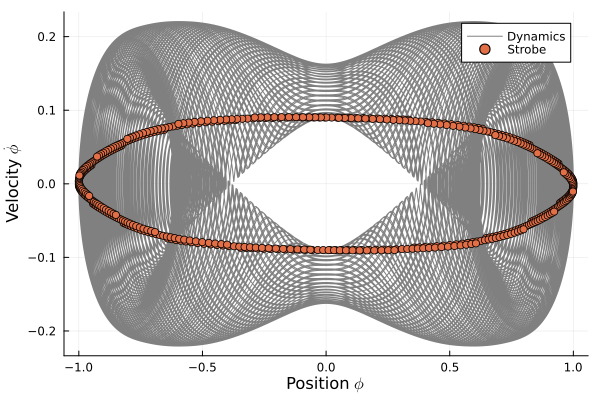

In [50]:
# Initial conditions
x0, v0 = 1, 0.0
r = [x0, v0]

#Function parameters
λ = 0.7
f(r, t) = Spin_compass.EOM_compass_unitless(r, t, λ)

#time paramaters (T = ωt)
t_initial, t_final, Nsteps = 0.0, 500*2*π, 100000
time_step = abs(t_final - t_initial) / Nsteps
time_param = (t_initial, t_final, Nsteps)


(tpoints, xpoints, vpoints) = Spin_compass.RK4(f, time_param, r)

#bounding xpoints
cartesian_proj_x = cos.(xpoints)
cartesian_proj_y = sin.(xpoints)

xpoints = atan.(cartesian_proj_y, cartesian_proj_x)

#Poincare map construction
(x_strobe, v_strobe) = Chaos_checking.stroboscope_dynamics(xpoints, vpoints, time_param)

plot(xpoints, vpoints, label = "Dynamics", color = "gray", )
fig = scatter!(x_strobe, v_strobe , label="Strobe", )

xlabel!(raw"Position $\phi$")
ylabel!(raw"Velocity $\dot{\phi}$")
savefig("image_results/torus from stroboscopic dynamics for lambda = 0.7.png");
display(fig)

### Chaotic Dynamics $\lambda >1$

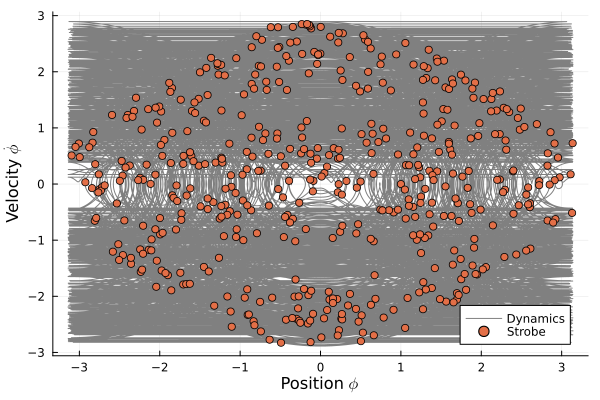

In [51]:
# Initial conditions
x0, v0 = 1, 0.0
r = [x0, v0]

#Function parameters
λ = 1.7
f(r, t) = Spin_compass.EOM_compass_unitless(r, t, λ)

#time paramaters (T = ωt)
t_initial, t_final, Nsteps = 0.0, 500*2*π, 100000
time_step = abs(t_final - t_initial) / Nsteps
time_param = (t_initial, t_final, Nsteps)


(tpoints, xpoints, vpoints) = Spin_compass.RK4(f, time_param, r)

#bounding xpoints
cartesian_proj_x = cos.(xpoints)
cartesian_proj_y = sin.(xpoints)

xpoints = atan.(cartesian_proj_y, cartesian_proj_x)

#Poincare map construction
(x_strobe, v_strobe) = Chaos_checking.stroboscope_dynamics(xpoints, vpoints, time_param)

plot(xpoints, vpoints, label = "Dynamics", color = "gray", )
fig = scatter!(x_strobe, v_strobe , label="Strobe", )

xlabel!(raw"Position $\phi$")
ylabel!(raw"Velocity $\dot{\phi}$")
savefig("image_results/torus from stroboscopic dynamics for lambda = 1.7.png");
display(fig)

## KR3: $B_0 - \omega$ Phase Diagram
- Create Julia function for calculating spectral entropy.
- Construct $B_0 - \omega$ Phase Diagram 

## Spentral Entropy Function

In [52]:
? Phase_diagram.b_omega_spectral_diagram_scanner() 

b*omega*spectral*diagram*scanner(time*param, scan*param)

# Description

Generates a 2D array with size (resolution , resolution) containing the spectral entropy of the spin compass'  dynamics as a function of both B and ω for a given range set by the `scan_param` input.

## Args

```
scan_param (Tuple{Float64, Float64, Float64, Float64, Int64}): range of lambda to be considered and the resolution of 
    the scan. `scan_param` must follow the format: 
    'scan_param = [B_initial, B_final, omega_initial, omega_final, resolution]'
```

## Returns

```
spectral_entropy_diagram (Array): 2D array containing the spectral entropy as a function of B and ω
```


In [13]:
? Phase_diagram.b_omega_spectral_diagram_scan_saver() 

b*omega*spectral*diagram*scan_saver()

# Description

Generates and saves the matrix containing the spectral entropy information as a function of B and ω information a txt file.

## Args

```
scan_param (Tuple{Float64, Float64, Float64, Float64, Int64}): range of lambda to be considered and the resolution of 
    the scan. `scan_param` must follow the format: 
    'scan_param = [B_initial, B_final, omega_initial, omega_final, resolution]'

save_filename (String): filename of the txt file where the spectral entropy diagram will be saved
```

## Returns

```
A txt file containing the spectral entropy diagram as a function of B and ω for the given range set by scan_param.
```


### Phase-Diagram Construction

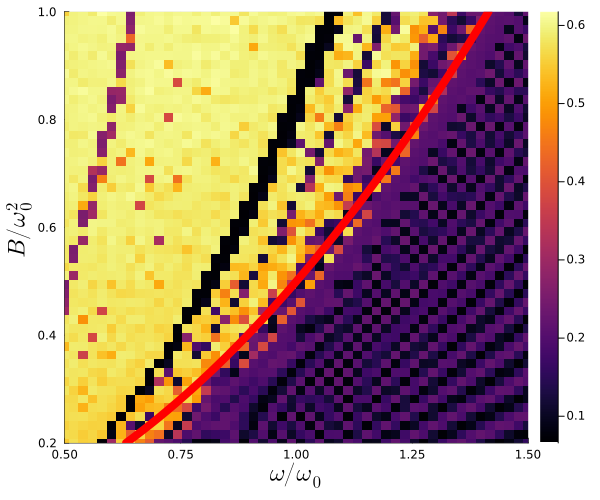

In [3]:
B_initial, B_final = 0.2, 1.0
omega_initial, omega_final = 0.5, 1.5
resolution = 50

scan_param = (B_initial, B_final, omega_initial, omega_final, resolution)

spectral_entropy_diagram = readdlm("raw_data/b omega phase diagram data.txt")

yaxisvalues = range(B_initial,B_final,resolution)

xaxisvalues = range(omega_initial,omega_final,resolution)

heatmap(xaxisvalues, yaxisvalues, spectral_entropy_diagram)

critical_omega_array = range(omega_initial, omega_final,1000)
theory_critical_line = 0.5 * critical_omega_array.^2
plot!(critical_omega_array,theory_critical_line, 
    ylimits=(B_initial,B_final), xlimits=(omega_initial,omega_final),
    linewidth = 8,linecolor = :red, legend = false)

ylabel!(raw"$B/\omega_0^2$",yguidefontsize = 16)
xlabel!(raw"$\omega/\omega_0$", xguidefontsize = 16)
plot!(size=(600,500))

## KR4: Chaotic Dynamics (Verification)
- Plot spectral entropy as a function of $\lambda$

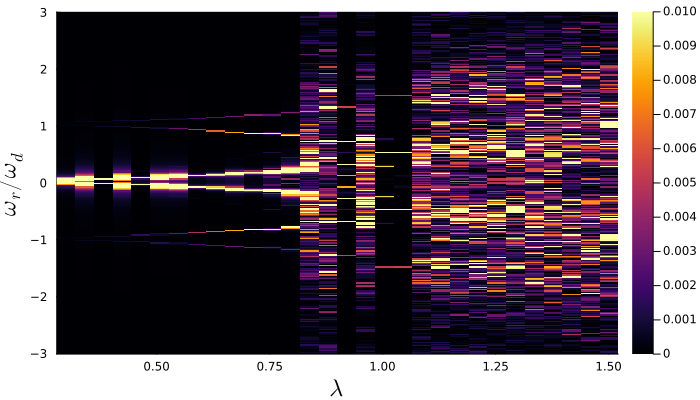

In [5]:
freq_spectrum = readdlm("raw_data/frequncy spectrum lambda scan.txt")
power_spectrum = readdlm("raw_data/power spectrum lambda scan.txt")

lambda_initial, lambda_final = 0.3, 1.5
freq_initial, freq_final = freq_spectrum[1], last(freq_spectrum)

xaxisvalues = range(lambda_initial,lambda_final,size(power_spectrum,2))
yaxisvalues = range(-3,3,300)

heatmap(xaxisvalues,yaxisvalues,power_spectrum[15557:15856,:],clims=(0,0.01))
ylabel!(raw"$\omega_r / \omega_{d}$", yguidefontsize = 16)
xlabel!(raw"$\lambda$", xguidefontsize = 16)
plot!(size=(700,400))

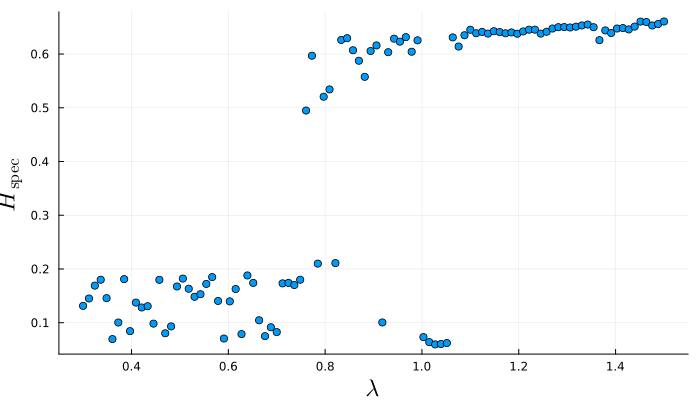

In [7]:
save_filename = "raw_data/entropy lambda scan.txt"

lambda_initial, lambda_final, resolution = 0.3, 1.5, 100
lambda_sample_array = range(lambda_initial, lambda_final, resolution)
lambda_spec_entropy_scan_data = readdlm(save_filename)

scatter(lambda_sample_array, lambda_spec_entropy_scan_data, xlims = (0.25, 1.55), label = "")
xlabel!(raw"$\lambda$", xguidefontsize = 16)
ylabel!(raw"$H_{\mathrm{spec}}$", yguidefontsize = 16)
plot!(size=(700,400))